# Introduction
This iPython notebook file provides the code used to train the model which evaluated the "Real and Fake Face Detection" dataset provided by kaggle using an extended InceptionV3 CNN, with the help of keras. All the images have been downloaded and stored in folders, which can be figured out by navigating through the directory names which are provided through the code.<br>
<br>
By the end of this notebook, the main aspects, and issues of this models are addressed, and an overall evaluation is made. A further explanation regarding the network architecture can be found on Network_Architecture.ipynb

In [9]:
#Importing all the relevant frameworks/libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras.backend as k
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout,BatchNormalization
from keras.applications.inception_v3 import InceptionV3
import cv2
import glob
import os
import sys
import shutil

In [10]:
#Preventing any unnecessary verbose from popping up
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [11]:
#Getting the current directory of this file
os.getcwd()

'C:\\Users\\vikra\\Downloads'

In [12]:
#Saving the directories of the real, and fake images
real_img_dir="D:\\Downloads\\real-and-fake-face-detection\\real_and_fake_face_detection\\real_and_fake_face\\training_real"
fake_img_dir="D:\\Downloads\\real-and-fake-face-detection\\real_and_fake_face_detection\\real_and_fake_face\\training_fake"
real_img_path=os.listdir(real_img_dir)
fake_img_path=os.listdir(fake_img_dir)

The variables "real_img_path", and ""fake_img_path" now contain direct paths to the image folder locations.<br> 
This is beneficial as it is now possible to locate them directly instead of making variable copies which is spacially expensive.

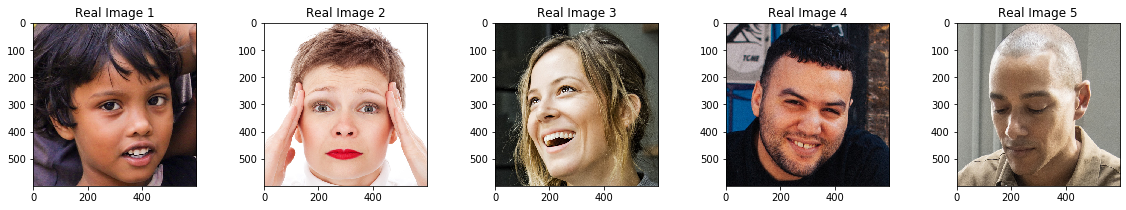

In [13]:
#Visualising the data
#Displaying the first 5 real images
i=0
fig, axs = plt.subplots(1, 5, figsize=(20, 3))
for ax, title in zip(axs, ['Real Image 1', 'Real Image 2', 'Real Image 3', 'Real Image 4', 'Real Image 5']):
    img=cv2.imread(real_img_dir + "\\" + real_img_path[i])
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB ))
    ax.set_title(title)
    ax.grid(False)
    i+=1
plt.show()

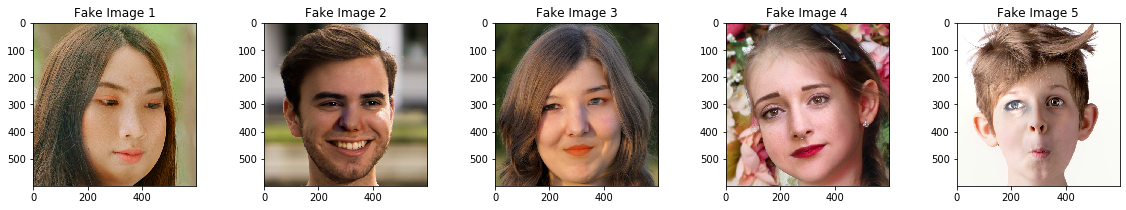

In [14]:
#Visualising the data
#Displaying the first 5 fake images
i=0
fig, axs = plt.subplots(1, 5, figsize=(20, 3))
for ax, title in zip(axs, ['Fake Image 1', 'Fake Image 2', 'Fake Image 3', 'Fake Image 4', 'Fake Image 5']):
    img=cv2.imread(fake_img_dir + "\\" + fake_img_path[i])
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB ))
    ax.set_title(title)
    ax.grid(False)
    i+=1
plt.show()

In [9]:
#Splitting the data into training, and testing sets
#2 folders with 2 empty subfolders each with names as per the directory are to be created first
#To be run only once, as once run, the split takes place

img_real_test = np.random.choice(
    real_img_path,
    size=round(len(real_img_path) * 0.2),
    replace=False,
    p=None)

img_real_train = list(set(real_img_path) - set(img_real_test)) 

img_fake_test = np.random.choice(
    fake_img_path,
    size=round(len(fake_img_path) * 0.2),
    replace=False,
    p=None)

img_fake_train = list(set(fake_img_path) - set(img_fake_test)) 

for img in img_real_train:
    shutil.copyfile(real_img_dir + "\\" + img, "D:\\Downloads\\train_img\\real_img" + "\\" + img) 

for img in img_fake_train:
    shutil.copyfile(fake_img_dir + "\\" + img, "D:\\Downloads\\train_img\\fake_img" + "\\" + img) 

for img in img_real_test:
    shutil.copyfile(real_img_dir + "\\" + img, "D:\\Downloads\\test_img\\real_img" + "\\" + img) 

for img in img_fake_test:
    shutil.copyfile(fake_img_dir + "\\" + img, "D:\\Downloads\\test_img\\fake_img" + "\\" + img) 

In [15]:
#Getting the new directories, for the training, and test images
train_directory="D:\\Downloads\\train_img"
test_directory="D:\\Downloads\\test_img"

#Scaling the training, and testing data using ImageDataGenerator, followed by grouping them into batches
#The InceptionV3 network takes input size of (299x299x3) and a batch size of 32 is being used
#Binary signifiesthe fact that there are only two output classes, that is real, and fake
training_data_scale=keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
training_data=training_data_scale.flow_from_directory(train_directory,class_mode="binary",
                                                      target_size=(299,299),batch_size=32,shuffle=True)

test_data_scale=keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
test_data=test_data_scale.flow_from_directory(test_directory,class_mode="binary",
                                              target_size=(299,299),batch_size=32,shuffle=True)

Found 1633 images belonging to 2 classes.
Found 408 images belonging to 2 classes.


These 1633 images signify the training set (approximately 80% of the total images(2041)).<br>
These 408 images signify the test set (approximately 20% of the total images(2041)).

In [16]:
#Creating the extended InceptionV3 model using pre-trained weights in keras

#Creating an instance of the pre-trained InceptionV3 network
#This model takes an input image of size (299,299,3)
input_img=keras.Input(shape=(299,299,3))
inceptionv3_part=InceptionV3(weights="imagenet",include_top=False)
for hidden_layer in inceptionv3_part.layers:
    hidden_layer.trainable=False

#Constructing the extension of the InceptionV3 network
#The output of this extension would be a single neuron that predicts whether the image is real, or fake (0, or 1)
X=MaxPooling2D(pool_size=(2,2))(inceptionv3_part(input_img))
X=BatchNormalization()(X)
X=Dropout(0.4)(X)
X=Flatten()(X)
X=Dense(256,activation="relu")(X)
X=Dense(1,activation="sigmoid")(X)

#Compiling this network into a model
model=keras.models.Model(inputs=input_img,outputs=X)
model.compile(loss=keras.losses.binary_crossentropy,optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
#Fitting this model to our own training data (and test data simultaneously)
model.fit_generator(training_data,epochs=10,validation_data=test_data)
performance=model.evaluate_generator(test_data)

print("Loss of the model on the test data : {}%".format(performance[0]*100))
print("Accuracy of the model on the test data : {}".format(performance[1]*100))

Epoch 1/10
52/52 [==============================] - 527s 10s/step - loss: 1.3556 - accuracy: 0.5542 - val_loss: 9.0511 - val_accuracy: 0.5098
Epoch 2/10
52/52 [==============================] - 414s 8s/step - loss: 0.6017 - accuracy: 0.7385 - val_loss: 5.9534 - val_accuracy: 0.5196
Epoch 3/10
52/52 [==============================] - 351s 7s/step - loss: 0.3939 - accuracy: 0.8267 - val_loss: 12.0509 - val_accuracy: 0.5025
Epoch 4/10
52/52 [==============================] - 349s 7s/step - loss: 0.3301 - accuracy: 0.8739 - val_loss: 3.3569 - val_accuracy: 0.5539
Epoch 5/10
52/52 [==============================] - 348s 7s/step - loss: 0.2327 - accuracy: 0.9032 - val_loss: 5.2462 - val_accuracy: 0.5098
Epoch 6/10
52/52 [==============================] - 348s 7s/step - loss: 0.1772 - accuracy: 0.9375 - val_loss: 1.8639 - val_accuracy: 0.5417
Epoch 7/10
52/52 [==============================] - 349s 7s/step - loss: 0.2512 - accuracy: 0.9069 - val_loss: 3.6571 - val_accuracy: 0.5392
Epoch 8/10


Note that the accuracy of the test set should be 51.715%, and the loss should be 519.214 (The precentage symbol mismatched).

In [18]:
#Saving the model to the local system
model.save("model_realfake.h5")

All the following evaluations of this model to be done in another file

# Conclusion
From training.ipynb, the training set results can be summarised as: <br>
training set accuracy : 97.06% <br>
test set accuracy : 51.715% <br>
<br>
It is clearly evident that for this model, the training set accuracy is much higher (ver high infact) than the test set accuracy. This clearly indicates the presence of overfitting to the training set.<br>
<br>
The reason the model overfit can be attributed to the complexity of the model, and the limited number of images to train on.
One of the main reasons the model was able to reach such high levels of accuracies on the training set in the first place was due to the complex nature of the network used (Extended InceptionV3 Network). Due to to only 1633 images to train on (way too less compared to the actual number required in real time applications for such a task, that is fake face detection), the complex model learnt how to classify these images extremely well, and ended up overfitting, by not being able to generalise for new images (test set).